### Vamos a cargar los datos

In [1]:
from arreglo_datos import vectorDatos
from transformacion import transformacion_datos
from livelossplot import PlotLosses

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
import torch

from modelo import Net
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import torch.optim as optim
import datetime


Bad key "legend.title_fontsize" on line 22 in
C:\Users\masan\.matplotlib\stylelib\notebook.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
%load_ext autoreload
%autoreload 2

Cargamos los datos de las etiquetas.

In [3]:
path = 'C:\\Users\\masan\\Desktop\\Mario\\ESFM\\Octavo Semestre\\Servicio Social\\Etiquetas'
dic_nombre_marcas = vectorDatos(path)

In [4]:
# Vamos a extraer los datos de cada imagen para poder hacer el split de datos.
vectorDeDatos_completos = []
nombreDeImagenes = []
for key in dic_nombre_marcas.keys():
    vectorDeDatos_completos.append(dic_nombre_marcas[key])
    nombreDeImagenes.append(key)

In [5]:
# True: Con esto solo trabajamos las lineas del borde de la carretera.
modo_lineas_borde = True

if modo_lineas_borde:
    vectorDeDatos = []
    for vector in vectorDeDatos_completos:
        vector_temp = [vector[0], vector[1],  vector[-1]]
        vectorDeDatos.append(vector_temp)

#### Vamos a dividir los datos en conjunto de entrenamiento y testeo (60-40).

In [6]:
entrenamiento_size = int(0.8*len(vectorDeDatos))
test_size = len(vectorDeDatos) - entrenamiento_size

datos_entrenamiento, datos_testeo = torch.utils.data.random_split(vectorDeDatos, [entrenamiento_size, test_size])

#### Vamos a cargar los datos con su respectiva transformación.

In [7]:
# Training
datos_transformados_training = []
for i in range(len(datos_entrenamiento)):
    try:
        sample = transformacion_datos(datos_entrenamiento[i])
        datos_transformados_training.append(sample)
    except ValueError:
        pass

# Testeo
datos_transformados_testeo = []
for i in range(len(datos_testeo)):
    try:
        sample = transformacion_datos(datos_testeo[i])
        datos_transformados_testeo.append(sample)
    except ValueError:
        pass

Vamos a hacer la funcion para graficar los puntos en las imagenes

In [8]:
def graficar_lineas_target(image, puntos, color, label):
    """
    Esta funcion se encarga de graficar las lineas target
    """
    punto = np.array(puntos)*150.0+55.0
    
    x1, y1 = [punto[0][0], punto[1][0]], [punto[0][1], punto[1][1]]
    x2, y2 = [punto[2][0], punto[3][0]], [punto[2][1], punto[3][1]]
    
    plt.plot(x1, y1, x2, y2, marker='x', color=color, label=label)
    plt.legend()
    plt.imshow(np.asarray(image), cmap='gray')
    
def graficar_lineas_pred(image, puntos, color, label):
    """
    Esta funcion se encarga de graficar las lineas pred
    """
    punto = np.array(puntos)*150.0+55.0
    
    x1, y1 = [punto[0][0], punto[1][0]], [punto[0][1], punto[1][1]]
    x2, y2 = [punto[2][0], punto[3][0]], [punto[2][1], punto[3][1]]
    
    plt.plot(x1, y1, x2, y2, marker='x', color=color, label=label)
    plt.legend()
    plt.imshow(np.asarray(image), cmap='gray')
    

def graficar_todos_puntos(image, puntos, gt_pts=None):
    """
    Esta funcion combina las lineas pred y target
    """
    puntos = puntos.to('cpu')
    gt_pts = gt_pts.to('cpu')

    punto = np.array(puntos)

    # plot ground truth points as green pts
    if gt_pts is not None:
        gt_pts = np.array(gt_pts)

    # Aqui desplegamos las lineas que predice la red
    graficar_lineas_pred(image, punto, color='red', label='Prediction')
    
    # Aqui graficamos las lineas target
    graficar_lineas_target(image, gt_pts, color='blue', label='Target')

    plt.imshow(image, cmap='gray')
    plt.legend()

### Prueba

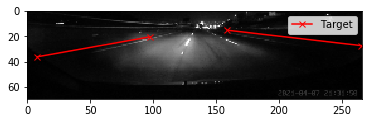

In [9]:
# Imagen aleatoria a imprimir
i = np.random.randint(0, len(datos_transformados_training))

img = datos_transformados_training[i]['image']
puntos = datos_transformados_training[i]['puntos']

graficar_lineas_target(img[0], puntos, color='red', label='Target')

---

#### Cargamos la arquitectura de la red.

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dropout_prob = 0.5
net = Net(dropout_prob)
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1792, out_features=1000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (drop6): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=500, out_features=8, bias=True)
)

### Para ver la cantidad de parametros que tenemos en nuestra red -> 2,745,864

#### Vamos a ver una muestra de los datos para ver que dimension tienen.

In [11]:
print('Number of images: ', len(datos_transformados_training))

for i in range(4):
    sample = datos_transformados_training[i]
    print(i, sample['image'].size(), sample['puntos'].size())

Number of images:  1790
0 torch.Size([1, 70, 266]) torch.Size([4, 2])
1 torch.Size([1, 70, 266]) torch.Size([4, 2])
2 torch.Size([1, 70, 266]) torch.Size([4, 2])
3 torch.Size([1, 70, 266]) torch.Size([4, 2])


#### Creamos el Train_Loader y el Test_Loader con un Batch de 50 y 5 respectivamente.

In [35]:
# Train Loader

# Probar 25, 30, 50
batch_size = 25
train_loader = DataLoader(datos_transformados_training, 
                          batch_size=batch_size,
                          shuffle=True)
# Test Loader
batch_size = 5 
test_loader = DataLoader(datos_transformados_testeo, 
                          batch_size=batch_size,
                          shuffle=True)

---

### En seguida vamos a cargar una muestra con el test loader.

In [36]:
# test the model on a batch of test images
def net_sample_output():
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['puntos']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        images = Variable(images)    
        images = images.to(device)

        # forward pass to get net output
        output_pts = net(images)
        images = images.to(device)
        output_pts = output_pts.to(device)
        
        # reshape to batch_size x 28 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 4, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [37]:
test_images, test_outputs, gt_pts = net_sample_output()

Vamos a graficar la salida, pero antes vamos a cargar las funciones que nos permiten visualizar la salida de nuestros datos y los que predice la CNN.

In [38]:
# visualize the output
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=5):

    for i in range(batch_size):
        plt.figure(figsize=(40,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data  # get the image from it's wrapper
        image = image.cpu()
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts
        
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts
        
        # call show_all_keypoints
        graficar_todos_puntos(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        #plt.axis('off')
    plt.show()

Ahora si vamos a visualizar los puntos.

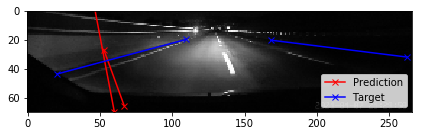

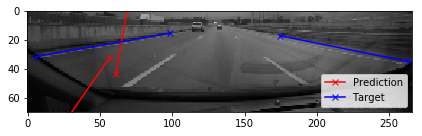

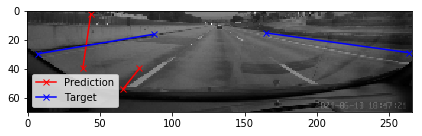

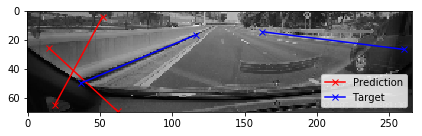

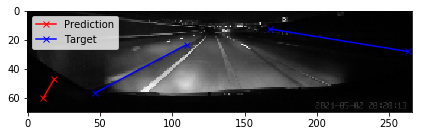

In [39]:
visualize_output(test_images, test_outputs, gt_pts)

In [40]:
gt_pts[0]

tensor([[-0.2300, -0.0778],
        [ 0.3648, -0.2370],
        [ 1.3827, -0.1556],
        [ 0.7546, -0.2333]], dtype=torch.float64)

In [41]:
test_outputs[0]

tensor([[-0.0155, -0.1903],
        [ 0.0785,  0.0683],
        [-0.0650, -0.4203],
        [ 0.0335,  0.0984]], device='cuda:0', grad_fn=<SelectBackward0>)

---

Ahora ya vamos a entrenar la red.

In [42]:
## TODO: Define the loss and optimization

criterion = nn.MSELoss().to(device)

init_factor = 0.01
#learning_rate = 0.001 * init_factor

# Probar con este LR
optimizer = optim.Adam(net.parameters(), lr=0.0005)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [43]:
loss_plt = []

def train_net(n_epochs):
    # prepare the net for training
    net.train()
    #liveloss = PlotLosses()
    for epoch in range(1, n_epochs + 1):  # loop over the dataset multiple times
        #logs = {}
        scheduler.step()
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['puntos']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = Variable(key_pts.type(torch.FloatTensor))
            images = Variable(images.type(torch.FloatTensor))

            # images, key_pts = Variable(images), Variable(key_pts)    
            images, key_pts = images.to(device), key_pts.to(device)
            
            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()
            
            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            
            #logs["Loss"] = running_loss/len(train_loader)
            
        loss_plt.append((running_loss)/len(train_loader)) 
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch,
                    running_loss / len(train_loader)))

    print('Finished Training')

In [44]:
n_epochs = 80

In [ ]:
train_net(n_epochs)

2022-09-23 15:45:52.928237 Epoch 1, Training loss 0.03494368240030275
2022-09-23 15:46:41.824739 Epoch 10, Training loss 0.007215248491977238
2022-09-23 15:47:36.505943 Epoch 20, Training loss 0.0040323812669763965


Vamos a imprimir el Loss para ver como es que nuestro modelo aprendio.

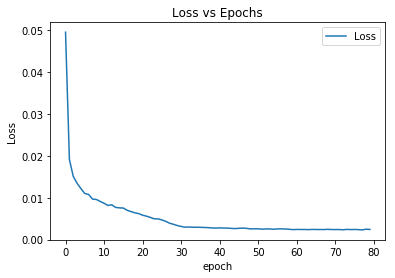

In [23]:
plt.plot(loss_plt,'-')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.title('Loss vs Epochs')
plt.show()

Como podemos observar, el modelo se tiende a aplanar en la epoca 60-80.

Vamos a guardar el aprendizaje de la CNN.

In [25]:
## TODO: change the name to something uniqe for each new model
model_dir = '../saved_models/'
model_name = 'chido3-2-lr.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

---

Ahora visualizaremos los resultados.

Si queremos visualizar los datos de otro entrenamiento aqui abajo cargaremos la ruta del otro modelo.

In [26]:
load_parameters = True
if(load_parameters):
    state_dict = torch.load('../saved_models/chido3-2-lr.pt')
    net.load_state_dict(state_dict)

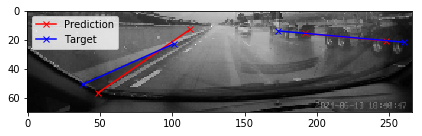

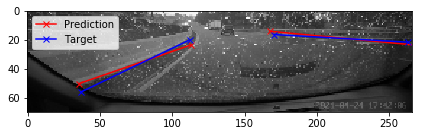

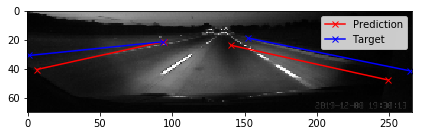

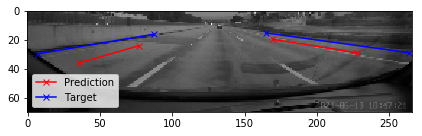

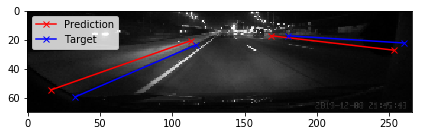

In [33]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)